# Importing Dataset

In [ ]:
# Insert Kaggle username and key 
import os
os.environ['KAGGLE_USERNAME'] = # username
os.environ['KAGGLE_KEY'] = # key


In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!unzip fake-and-real-news-dataset.zip

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
# from tensorflow.keras import layers
import gensim
pd.options.mode.chained_assignment = None

# 1. Loading the dataset

In [2]:
fake_news = pd.read_csv("Fake.csv")
real_news = pd.read_csv("True.csv")

In [3]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


<li>Creating the target variable 'fake', with a value of 1 if an article is fake and 0 otherwise.
<li>Joining both dataframes to form the complete dataframe.</li>

In [5]:
fake_news['fake'] = 1
real_news['fake'] = 0
news = pd.concat([fake_news, real_news])
news.reset_index(inplace=True, drop=True)

In [6]:
news.head()

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [7]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [8]:
counts = news['fake'].value_counts()
fake = counts[1]
real = counts[0]
print('The dataset consists of %d fake news articles and %d real news articles' % (fake,real))

The dataset consists of 23481 fake news articles and 21417 real news articles


# 2. Data Cleaning

### 2.1 Missing data

In [9]:
#Check for missing data
news.isna().value_counts()

title  text   subject  date   fake 
False  False  False    False  False    44898
dtype: int64

### 2.2 Duplicate articles

In [10]:
# Check for duplicates
news['all_text'] = news['title'] + ' '+ news['text'] 
num_dup = len(news) - len(news['all_text'].unique())
print('There are a total of %d duplicates in the dataset' % num_dup)

There are a total of 5793 duplicates in the dataset


In [11]:
news.drop_duplicates(subset=['all_text'], inplace = True)
news.shape

(39105, 6)

In [12]:
updated_counts = news['fake'].value_counts()
updated_fake = updated_counts[1]
updated_real = updated_counts[0]
print('After cleaning, the dataset consists of %d fake news articles and %d real news articles' % (updated_fake,updated_real))

After cleaning, the dataset consists of 17908 fake news articles and 21197 real news articles


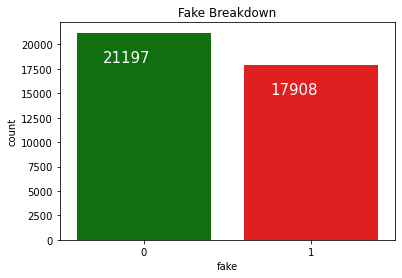

In [13]:
ax = sns.countplot(x='fake', data=news, palette=['g','r'])
ax.set_title('Fake Breakdown')
for i in ax.patches:
    ax.annotate(f'\n{i.get_height()}', (i.get_x() + 0.3, i.get_height()), ha='center', va='top', color='white', size=15)

After removing duplicates, we now have 21197 real news and 17908 fake news articles to work with.

### 2.3 Removing publisher information for real news
<li>With a quick scan of the real news articles in our dataset, we realise that most texts start off with publisher information, specifically Reuters <b>(eg. 'WASHINGTON (Reuters) -')</b>.</li>
<li>We want to be able to generalise our predictions models to articles from any publisher, hence we drop publisher information from our dataset.</li>

In [14]:
with_publisher_info = news['text'].str.contains('^.+ \(Reuters\) - ', regex=True).sum()
print('A total of %d out of %d real news articles contain publisher information' % (with_publisher_info,updated_real))

A total of 19557 out of 21197 real news articles contain publisher information


In [15]:
news['text'] = news['text'].map(lambda x: re.sub(r'^.+ \(Reuters\) - ','',x))
news[news['fake']== 0]['text']

23481    The head of a conservative Republican faction ...
23482    Transgender people will be allowed for the fir...
23483    The special counsel investigation of links bet...
23484    Trump campaign adviser George Papadopoulos tol...
23485    President Donald Trump called on the U.S. Post...
                               ...                        
44893    NATO allies on Tuesday welcomed President Dona...
44894    LexisNexis, a provider of legal, regulatory an...
44895    In the shadow of disused Soviet-era factories ...
44896    Vatican Secretary of State Cardinal Pietro Par...
44897    Indonesia will buy 11 Sukhoi fighter jets wort...
Name: text, Length: 21197, dtype: object

In [16]:
# update 'all_text' column
news['all_text'] = news['title'] + ' ' + news['text'] 

### 2.4 Articles with no text body

In [17]:
news['length'] = news['text'].map(lambda x: len(x.split()))
news[news['length']==0]

,title,text,subject,date,fake,all_text,length
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",1,TAKE OUR POLL: Who Do You Think President Trum...,0
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",1,Joe Scarborough BERATES Mika Brzezinski Over “...,0
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",1,WATCH TUCKER CARLSON Scorch Sanctuary City May...,0
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017",1,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,0
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017",1,SHOCKER: Public School Turns Computer Lab Into...,0
...,...,...,...,...,...,...,...
21775,MEGYN KELLY SETS A CONFUSED LIBERAL STRAIGHT O...,,left-news,"May 6, 2015",1,MEGYN KELLY SETS A CONFUSED LIBERAL STRAIGHT O...,0
21780,OUTRAGEOUS VIDEO! OBAMA KEEPS STIRRING THE FLA...,,left-news,"May 5, 2015",1,OUTRAGEOUS VIDEO! OBAMA KEEPS STIRRING THE FLA...,0
21787,(VIDEO) PAM GELLER HAMMERS CNN HOST: “Did Chri...,,left-news,"May 4, 2015",1,(VIDEO) PAM GELLER HAMMERS CNN HOST: “Did Chri...,0
21813,(VIDEO) MOM OF THE YEAR! WHEN YOUR MOM CATCHES...,,left-news,"Apr 27, 2015",1,(VIDEO) MOM OF THE YEAR! WHEN YOUR MOM CATCHES...,0


In [18]:
# 446 fake articles with no text body, 1 real article with no text body
news[news['length']==0]['fake'].value_counts()

1    446
0      1
Name: fake, dtype: int64

### 2.5 Identifying and padding punctuation marks

In [19]:
def getPunctuations(text_col):
    '''
    Parameters
    ----------
    text_col : Series of strings
    
    Returns
    -------
    punctuations : string of all non-alphanumeric & non-space characters
    '''
    regx = re.compile(r'[\W_]')
    res = []
    for i in text_col:
        res.extend(regx.findall(i))
    res = set(res)
    spaces = ['\u200a', '\u200b', '\u200f', '\u202a', '\u200e', '\xa0', '\u202c', '\ufeff', '\n', '\r', '\t', ' ']
    for s in spaces:
        res.remove(s)
    
    punctuations = ''
    for r in res:
        punctuations += r
        
    return punctuations

# pad punctuations with spaces to allow tokenizer to correctly identify words
def padPunctuation(data):
    res = []
    for i in data:
        x = i.translate(str.maketrans({key: " {0} ".format(key) for key in punctuations})) # account for punctuations used in certain text not included in string.punctuation
        res.append(x)
    return res

In [20]:
punctuations = getPunctuations(news['all_text'])
news['title'] = padPunctuation(news['title'])
news['text'] = padPunctuation(news['text'])
news['all_text'] = padPunctuation(news['all_text'])

# 3. Exploratory Data Analysis

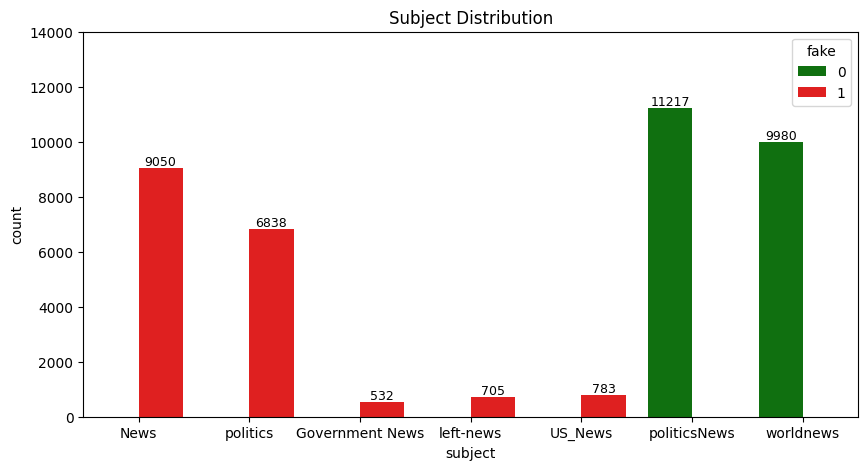

In [21]:
# Subject distribution
plt.figure(figsize=(10,5))
ax = sns.countplot(x='subject', data=news, hue='fake', palette=['g','r'])
ax.set_title('Subject Distribution')
ax.set(ylim=(0, 14000))
for p in ax.patches:
    ax.annotate(f'\n{p.get_height().astype(int)}', (p.get_x()+0.2, p.get_height() + 1000), ha='center', va='top', color='black', size=9)


<Figure size 1000x500 with 0 Axes>

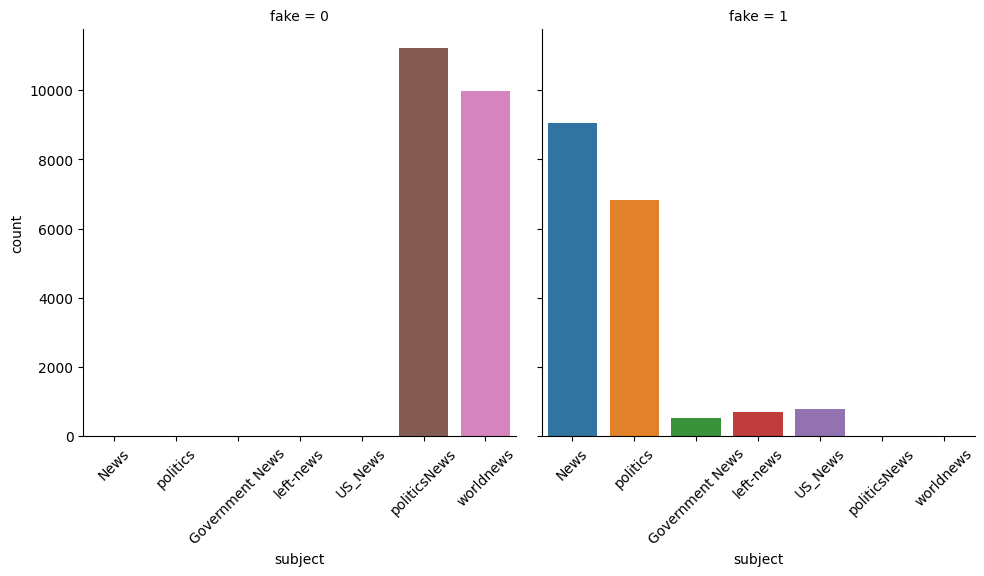

In [22]:
# Segmenting subject distribution by target

plt.figure(figsize=(10,5))
g = sns.catplot(x="subject", col="fake", data=news, kind="count")

#Rotating the xlabels
g.set_xticklabels(rotation=45)


It appears that all real news fall under either of the subjects 'politicsNews' or 'worldnews', while a significant proportion of fake news are categorised as 'News' or 'politics'.

<AxesSubplot:xlabel='length', ylabel='Count'>

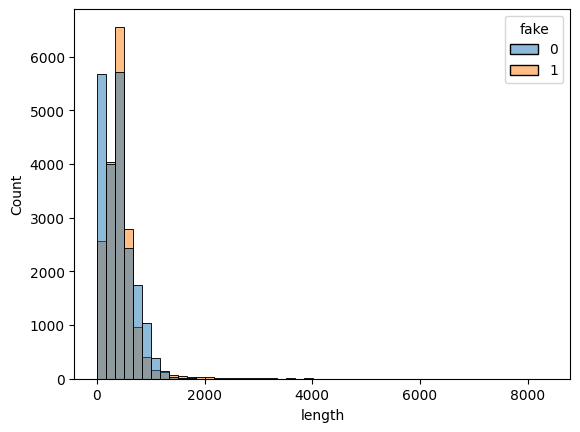

In [23]:
# Overall word length distribution
news['length'] = news['text'].map(lambda x: len(x.split()))
sns.histplot(x='length', data=news, bins = 50, hue='fake')

<AxesSubplot:xlabel='length', ylabel='Count'>

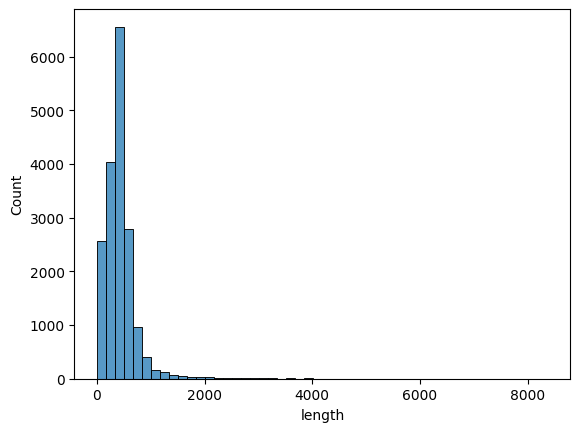

In [24]:
# Fake data distribution of word length
sns.histplot(x='length', data=news.loc[news['fake'] == 1], bins = 50)

<AxesSubplot:xlabel='length', ylabel='Count'>

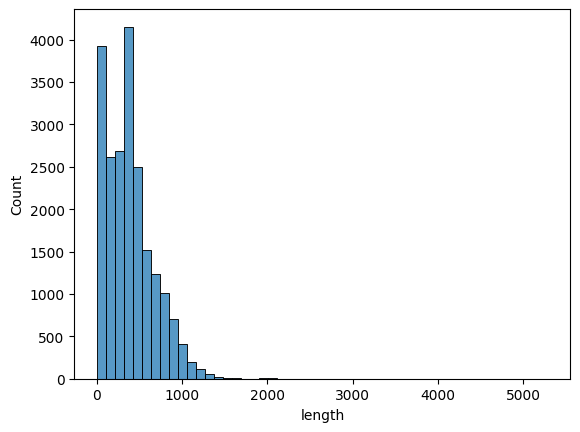

In [25]:
sns.histplot(x='length', data=news.loc[news['fake'] == 0], bins = 50)

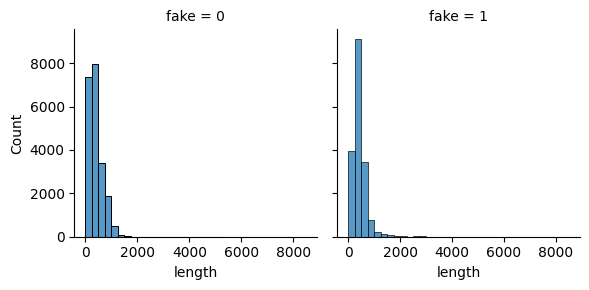

In [26]:
# Combining the 2 plots above 

g = sns.FacetGrid(news, col="fake")
g.map(sns.histplot, "length", binwidth=250)

In [27]:
from wordcloud import WordCloud, STOPWORDS
#Word Cloud
stopwords = set(STOPWORDS)
def give_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=0
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

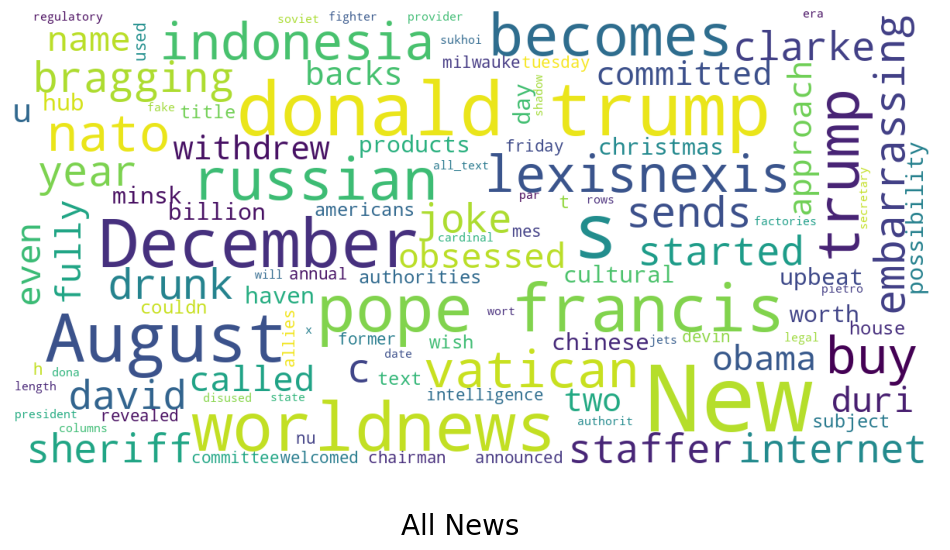

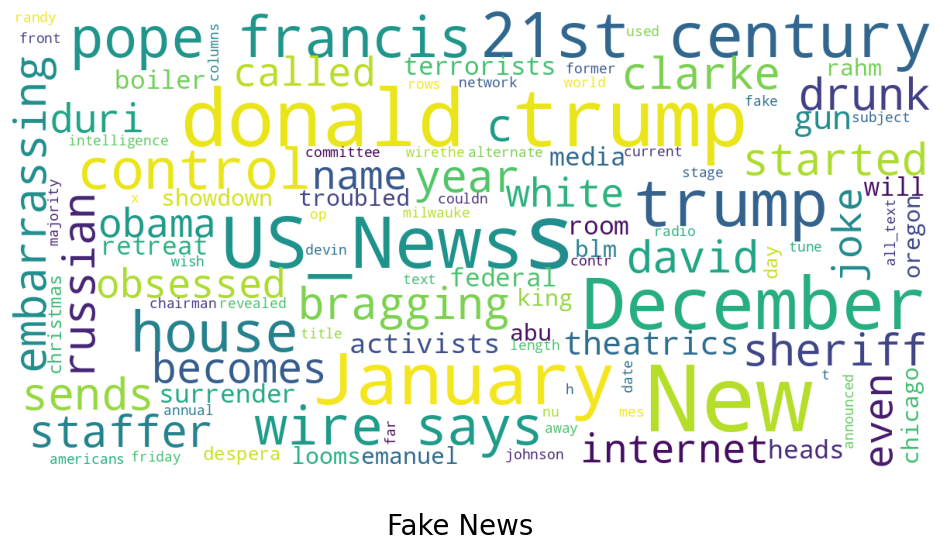

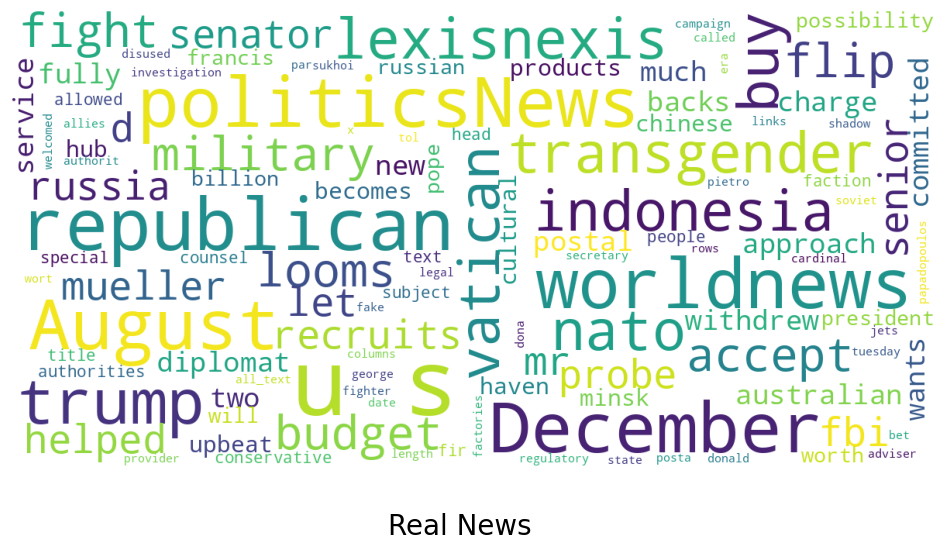

In [28]:
give_wordcloud(news,'All News')
give_wordcloud(news[news['fake'] == 1], 'Fake News')
give_wordcloud(news[news['fake'] == 0], 'Real News')

Fake news shows emotive and loaded language such as 'Drunk' and 'Obsessed', and biased persons such as Donald Trump are often mentioned.
Real news shows distinguished establishments such as 'NATO'and 'Reuters', and does not contain any emotive language. Instead, the words lean more towards factual.

In [29]:
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# # Getting sentiment values from all_text

# analyzer = SentimentIntensityAnalyzer()
# news['sentiment_score'] = [analyzer.polarity_scores(x)['compound'] for x in news['all_text']]
# news.head()

# 4. Testing our hypotheses:
<li>We hypothesise that article titles alone are strong predictors of whether or not they headline fake news.  We further speculate that the addition of article text as a predictor will further improve fake news detection accuracy.</li>
<li>We hypothesise that deep learning methods trained on article titles will perform better than classical machine learning methods on metadata extracted from the same titles.</li>

## Splitting the dataset

In [21]:
target = news['fake']
features = news.drop('fake', axis=1)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=1,test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.25) # 0.25 x 0.8 = 0.2, #20% valid

# 5. Hypothesis 1: Testing classical machine learning models

# 6. Hypothesis 2: Testing Neural Network models

## 6.1 Training a simple RNN model on titles only
https://www.kaggle.com/code/therealcyberlord/fake-news-detection-using-rnn

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize(train_data,val_data,test_data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_data)

    train_data = tokenizer.texts_to_sequences(train_data)
    val_data = tokenizer.texts_to_sequences(val_data)
    test_data = tokenizer.texts_to_sequences(test_data)
    vocab = tokenizer.word_index
    return train_data,val_data,test_data,vocab

def pad(train_data,val_data,test_data,max_len):
    train_data = pad_sequences(train_data, padding='post', maxlen=max_len)
    val_data = pad_sequences(val_data, padding='post', maxlen=max_len)
    test_data = pad_sequences(test_data, padding='post', maxlen=max_len)
    return train_data,val_data,test_data

In [24]:
X_train_title,X_val_title,X_test_title,vocab_title = tokenize(X_train['title'],X_val['title'],X_test['title'])
max_vocab_title = len(vocab_title) + 1 # Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.

# get length of longest title and pad all shorter titles to match length
max_len_title = max([len(x) for x in X_train_title] + [len(x) for x in X_test_title])
X_train_title,X_val_title,X_test_title = pad(X_train_title,X_val_title,X_test_title,max_len_title)

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Dropout

rnn_model = Sequential([
    Embedding(max_vocab_title, 100, input_length=max_len_title),
    Bidirectional(tf.keras.layers.SimpleRNN(16)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 52, 100)           1729200   
                                                                 
 bidirectional (Bidirectiona  (None, 32)               3744      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,732,977
Trainable params: 1,732,977
Non-trainable params: 0
_________________________________________________________________


In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
rnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
%%time
history_title = rnn_model.fit(X_train_title, y_train, epochs=10, 
                    validation_data=(X_val_title, y_val), batch_size=30, 
                    shuffle=True, callbacks=[early_stop])

Epoch 1/10
783/783 [==============================] - 124s 155ms/step - loss: 0.4090 - accuracy: 0.8507 - val_loss: 0.2013 - val_accuracy: 0.9545
Epoch 2/10
783/783 [==============================] - 125s 159ms/step - loss: 0.1543 - accuracy: 0.9671 - val_loss: 0.1200 - val_accuracy: 0.9655
Epoch 3/10
783/783 [==============================] - 126s 162ms/step - loss: 0.0869 - accuracy: 0.9818 - val_loss: 0.0980 - val_accuracy: 0.9682
Epoch 4/10
783/783 [==============================] - 124s 159ms/step - loss: 0.0540 - accuracy: 0.9896 - val_loss: 0.0830 - val_accuracy: 0.9721
Epoch 5/10
783/783 [==============================] - 124s 159ms/step - loss: 0.0363 - accuracy: 0.9928 - val_loss: 0.0829 - val_accuracy: 0.9689
Epoch 6/10
783/783 [==============================] - 125s 160ms/step - loss: 0.0242 - accuracy: 0.9962 - val_loss: 0.0833 - val_accuracy: 0.9707
Epoch 7/10
783/783 [==============================] - 128s 163ms/step - loss: 0.0169 - accuracy: 0.9976 - val_loss: 0.0862 -

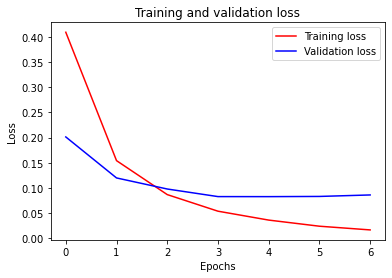

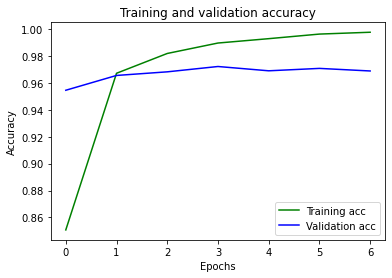

In [28]:
history_dict = history_title.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history_title.epoch

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [52]:
rnn_model.evaluate(X_train_title, y_train)

734/734 [==============================] - 16s 22ms/step - loss: 0.0176 - accuracy: 0.9969


[0.017585184425115585, 0.9968886971473694]

In [53]:
rnn_model.evaluate(X_val_title, y_val)

245/245 [==============================] - 5s 21ms/step - loss: 0.0829 - accuracy: 0.9689


[0.08287585526704788, 0.9689298272132874]

In [29]:
rnn_model.evaluate(X_test_title, y_test)

245/245 [==============================] - 6s 24ms/step - loss: 0.0747 - accuracy: 0.9726


[0.07471625506877899, 0.9726377725601196]

## 6.2 Training an LSTM model on both title and text

### 6.2.1 Training the word2vec model on the dataset

<li>There are certain characteristics distinct to fake news that would be helpful for prediction (eg. number of capitalised words, punctuations etc. However, since word2vec trains better on words in their raw form, we will preprocess the text for this purpose while extracting the distinctive characteristics and train them in another classification model.</li>
<li>Since the use of language and choice of vocabulary differs between real and fake news, we will not lemmatise/stem the words in our corpus</li>


In [30]:
# # only words (can have - or ') will be generated as tokens
# create a list of elements each containing a list of words from each article in the corpus
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize

def corpus_to_vect(df_column):
    corpus_tokens = []
    stop_words = set(stopwords.words("english"))
    rtokenizer = RegexpTokenizer(r'[a-zA-Z\'\-]+') # matches any word that contains only letters, hyphens, and apostrophes
    docs = df_column.values
    for doc in docs:
        sents = sent_tokenize(doc)
        doc_tokens = []
        for sent in sents:
            sent_lowered = sent.lower()
            words = rtokenizer.tokenize(sent_lowered) # convert all words to lower case
            filtered = [word.strip() for word in words if word not in stop_words and len(word) > 1] # filter out stopwords
            doc_tokens.extend(filtered)
        corpus_tokens.append(doc_tokens)
    return corpus_tokens

In [31]:
# tokenizing the 'text' column 
X_train_alltext = corpus_to_vect(X_train['all_text'])
X_val_alltext = corpus_to_vect(X_val['all_text'])
X_test_alltext = corpus_to_vect(X_test['all_text'])

In [32]:
 # all tokens generated in the first article
print(X_train_alltext[0])

['trump', 'meet', 'wilbur', 'ross', 'possible', 'choice', 'commerce', 'secretary', 'president', 'elect', 'donald', 'trump', 'meet', 'sunday', 'billionaire', 'investor', 'wilbur', 'ross', 'possible', 'candidate', 'commerce', 'secretary', 'new', 'administration', 'spokesman', 'trump', 'transition', 'team', 'said', 'saturday', 'trump', 'takes', 'office', 'jan', 'also', 'meet', 'others', 'sunday', 'including', 'new', 'jersey', 'governor', 'chris', 'christie', 'former', 'new', 'york', 'mayor', 'rudy', 'giuliani', 'kris', 'kobach', 'kansas', 'secretary', 'state', 'architect', 'anti', 'immigration', 'efforts', 'says', 'advising', 'trump', 'immigration', 'issues', 'trump', 'transition', 'team', 'official', 'said', 'senior', 'appointment', 'could', 'announced', 'soon']


In [33]:
# training word2vec on the 'text' corpus to form the embedding layer
from gensim.models import Word2Vec

EMBEDDING_DIM = 100
w2v = Word2Vec(
    sentences = X_train_alltext,
    vector_size = EMBEDDING_DIM,
    window = 5,
    min_count = 1
)

In [34]:
num = len(w2v.wv)
print('There are a total of %d words in the vocabulary of our trained word2vec model.' % num)

There are a total of 90465 words in the vocabulary of our trained word2vec model.


In [35]:
w2v.wv["donald"]

array([ 1.1301795 ,  0.8599911 ,  1.999779  , -2.2605572 , -2.6562307 ,
       -1.6714722 , -2.9911723 , -2.117089  ,  0.13456759, -1.0364605 ,
        2.6944547 , -0.40811843,  1.1685084 , -0.9120485 ,  1.6732106 ,
        1.1625098 , -0.2936939 , -0.5666571 ,  1.6329349 , -0.5167829 ,
       -1.539946  ,  0.66901755,  2.56595   , -0.94646525, -0.86651444,
       -1.3851362 , -1.3277246 ,  0.62176245,  1.2032763 , -1.2942504 ,
       -0.19298296, -1.8489063 ,  0.9242528 ,  0.95529854,  1.5164756 ,
       -0.62196344, -0.4817194 ,  1.0715506 , -1.0616355 , -2.6070638 ,
        2.0732827 , -0.08551539, -1.4328765 ,  2.771437  , -2.4256217 ,
       -1.4827737 , -2.4394426 ,  0.39826992, -2.116234  ,  0.8769617 ,
       -0.12811795, -0.71496314, -0.91209334,  3.3301618 ,  2.4786735 ,
        0.41126215, -2.2313044 ,  1.9140922 , -0.48519492, -2.8355198 ,
       -0.6824072 , -1.5363078 , -0.5789607 ,  1.6335855 , -1.5898681 ,
        2.129536  , -1.169402  ,  0.663133  ,  1.2713561 , -3.76

In [36]:
w2v.wv.most_similar("trump")

[('elect', 0.6656776070594788),
 ('course', 0.5345160961151123),
 ('conway', 0.5009206533432007),
 ('actually', 0.4775644540786743),
 ('inertial', 0.4765152335166931),
 ('instead', 0.47498875856399536),
 ('romney', 0.47215232253074646),
 ('obama', 0.4698413014411926),
 ('cruz', 0.46144190430641174),
 ('ayer', 0.46108171343803406)]

### 6.2.2 Preparing the neural network model inputs

In [37]:
X_train_alltext,X_val_alltext,X_test_alltext, vocab_alltext = tokenize(X_train_alltext,X_val_alltext,X_test_alltext)
max_vocab_alltext = len(vocab_alltext) + 1

In [38]:
# all token indexes generated from the first article
print(X_train_alltext[0])

[1, 483, 5274, 1956, 327, 933, 1940, 116, 3, 634, 11, 1, 483, 215, 1244, 3514, 5274, 1956, 327, 140, 1940, 116, 8, 60, 242, 1, 904, 344, 2, 381, 1, 963, 75, 1187, 9, 483, 369, 215, 74, 8, 1539, 249, 1165, 1507, 31, 8, 142, 884, 5604, 3142, 8601, 6432, 2304, 116, 7, 9088, 164, 213, 410, 68, 7230, 1, 213, 319, 1, 904, 344, 127, 2, 278, 2783, 18, 503, 718]


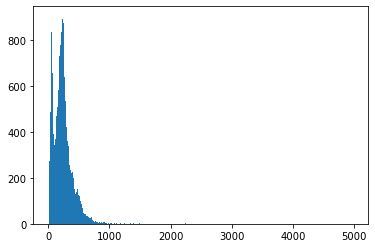

In [39]:
article_lens = np.array([len(index) for index in X_train_alltext])
plt.hist(article_lens, bins=500)
plt.show()

In [40]:
len_1000 = article_lens[article_lens < 1000]
print('%d out of %d articles have less than 1000 words' % (len(len_1000),len(article_lens)))

23361 out of 23463 articles have less than 1000 words


<li>Since the inputs to the neural network have to be of the same size, we have to pad each article in the dataset.</li>
<li>Since the majority of articles have less than 1000 words, we pad shorter news articles and truncate longer articles.</li>

In [41]:
max_len_alltext = 1000
X_train_alltext,X_val_alltext,X_test_alltext = pad(X_train_alltext,X_val_alltext,X_test_alltext,max_len_alltext)

In [42]:
# creating a weight matrix to retain weights learned by word2vec in the embedding layer later on
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # create weight matrix with number of rows = vocab_size and number of columns = number of embedding dimensions
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # for each word in the vocab, store its vector created by the word2vec model
    for word, row_index in vocab.items():
        weight_matrix[row_index] = model.wv[word]
    return weight_matrix

In [43]:
embedding_vectors = get_weight_matrix(w2v, vocab_alltext)

### 6.2.3 Training the neural network

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout

lstm_model = Sequential([
    Embedding(max_vocab_alltext, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=max_len_alltext, trainable=False),
    Bidirectional(LSTM(units=128)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [45]:
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [46]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         9046600   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 9,281,353
Trainable params: 234,753
Non-trainable params: 9,046,600
_________________________________________________________________


In [47]:
%%time
history_alltext = lstm_model.fit(X_train_alltext, y_train, epochs=10, 
                                validation_data=(X_val_alltext, y_val), batch_size=30, 
                                shuffle=True, callbacks=[early_stop])

Epoch 1/10
783/783 [==============================] - 71s 85ms/step - loss: 0.1921 - accuracy: 0.9339 - val_loss: 0.0961 - val_accuracy: 0.9655
Epoch 2/10
783/783 [==============================] - 65s 83ms/step - loss: 0.0892 - accuracy: 0.9699 - val_loss: 0.0721 - val_accuracy: 0.9742
Epoch 3/10
783/783 [==============================] - 64s 82ms/step - loss: 0.0707 - accuracy: 0.9754 - val_loss: 0.0655 - val_accuracy: 0.9771
Epoch 4/10
783/783 [==============================] - 67s 86ms/step - loss: 0.0575 - accuracy: 0.9810 - val_loss: 0.0550 - val_accuracy: 0.9804
Epoch 5/10
783/783 [==============================] - 66s 84ms/step - loss: 0.0530 - accuracy: 0.9820 - val_loss: 0.0519 - val_accuracy: 0.9811
Epoch 6/10
783/783 [==============================] - 67s 86ms/step - loss: 0.0405 - accuracy: 0.9858 - val_loss: 0.0605 - val_accuracy: 0.9797
Epoch 7/10
783/783 [==============================] - 66s 84ms/step - loss: 0.0525 - accuracy: 0.9823 - val_loss: 0.0652 - val_accuracy:

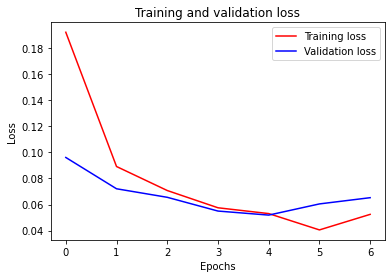

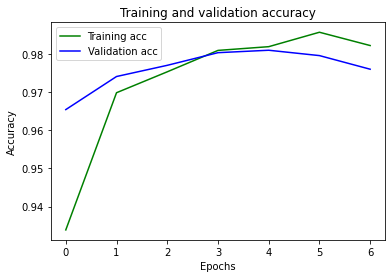

In [48]:
history_dict = history_alltext.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history_alltext.epoch

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
lstm_model.evaluate(X_train_alltext, y_train)

734/734 [==============================] - 28s 38ms/step - loss: 0.0388 - accuracy: 0.9868


[0.038836151361465454, 0.9868303537368774]

In [55]:
lstm_model.evaluate(X_val_alltext, y_val)

245/245 [==============================] - 9s 38ms/step - loss: 0.0519 - accuracy: 0.9811


[0.051883868873119354, 0.9810765981674194]

In [51]:
lstm_model.evaluate(X_test_alltext, y_test)

245/245 [==============================] - 10s 39ms/step - loss: 0.0546 - accuracy: 0.9830


[0.05456031858921051, 0.9829944968223572]

### 6.2.4 Hyperparameter tuning for neural network